# Task 1.1: Prediction with RNN

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.load_data import get_data, load_daily_consumptions
from src.train import FederatedLearning
from src.config import Config, load_train_config

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import torch
torch.manual_seed(101)

## Specify parameters

### Manually set config

In [4]:
kwargs = {
    # Main mode
    "mode": "prediction",

    # Model config
    "model": "RNN",  # LSTM or RNN
    "hidden_dim": 32,
    "num_layers": 1,
    "dropout": 0.0,

    # Training config
    "epochs": 1000,
    "lr": 3e-4,
    "batch_size": 128
}

config = Config(**kwargs)

In [5]:
# Save config
# config.save("default_pred_rnn")

### Load saved config

In [6]:
config = load_train_config("config_default_pred_rnn")
print(config)

Config loaded from: config/config_default_pred_rnn.json
CONFIG:
  mode: prediction
  test_size: 0.2
  val_size: 0.1
  shuffle: True
  seed: 42
  model: RNN
  input_dim: 1
  hidden_dim: 32
  output_dim: 1
  num_layers: 1
  dropout: 0.0
  epochs: 1000
  lr: 0.0003
  batch_size: 128
  eval_steps: 50


## Run FL training

In [7]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(config)

In [8]:
fl = FederatedLearning(config)
fl.train(x_train, y_train, x_val, y_val)

TRAIN:
  Epoch: 1,  train loss: 141.32799, val loss: 665.44879
  Epoch: 50,  train loss: 116.49046, val loss: 631.30676
  Epoch: 100,  train loss: 111.35426, val loss: 514.01666
  Epoch: 150,  train loss: 23.60154, val loss: 66.94907
  Epoch: 200,  train loss: 24.77463, val loss: 58.38889
  Epoch: 250,  train loss: 22.66065, val loss: 56.91312
  Epoch: 300,  train loss: 14.70448, val loss: 55.41048
  Epoch: 350,  train loss: 18.85611, val loss: 53.64981
  Epoch: 400,  train loss: 18.06785, val loss: 51.58434
  Epoch: 450,  train loss: 15.68882, val loss: 50.73308
  Epoch: 500,  train loss: 17.47280, val loss: 50.07452
  Epoch: 550,  train loss: 18.49281, val loss: 49.75063
  Epoch: 600,  train loss: 18.47977, val loss: 49.68550
  Epoch: 650,  train loss: 17.46437, val loss: 49.48973
  Epoch: 700,  train loss: 23.60389, val loss: 49.41882
  Epoch: 750,  train loss: 17.25061, val loss: 49.37534
  Epoch: 800,  train loss: 15.97275, val loss: 49.09836
  Epoch: 850,  train loss: 16.56656, v

### Analysis

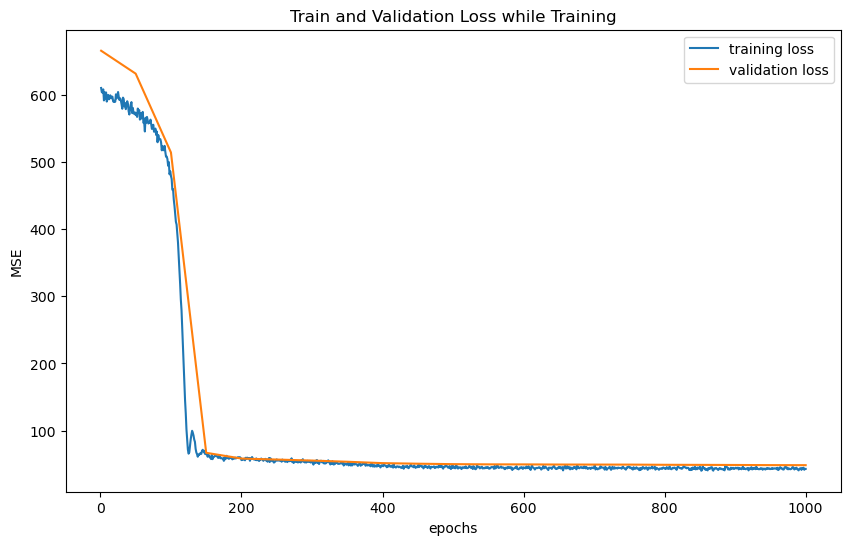

In [9]:
fl.plot_training_loss()

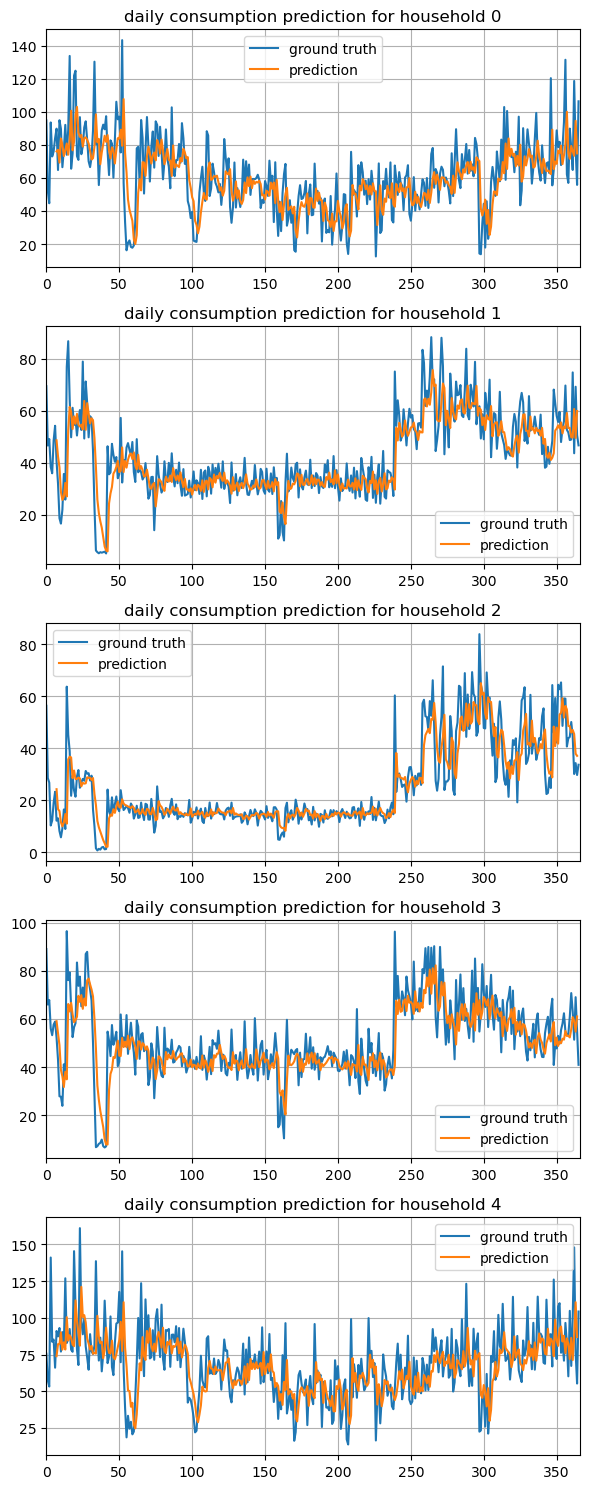

In [48]:
fl.plot_daily_consumption_prediction()

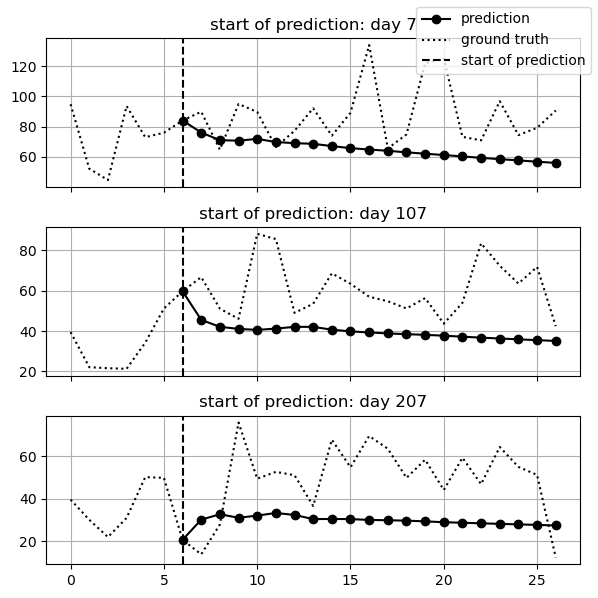

In [52]:
fl.plot_recursive_time_evolution()

METRICS:
  Test MSE: 48.648006439208984


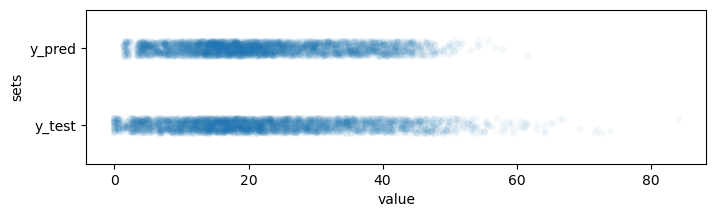

In [53]:
y_pred = fl.evaluation_metrics(x_test, y_test)
plt.figure(figsize=(8,2))
sns.stripplot(
  pd.DataFrame({"y_pred": y_pred.numpy()[:,0], "y_test": y_test.numpy().reshape(-1)}).melt(var_name="sets"),
  x="value", y="sets", alpha=.05,
);

## Run training with aggregated data

In [15]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(config)

# Stack data to aggregate all households to one
x_train, x_val, x_test = [arr.reshape(1, arr.shape[0] * arr.shape[1], arr.shape[2]) for arr in [x_train, x_val, x_test]]
y_train, y_val, y_test = [arr.reshape(1, arr.shape[0] * arr.shape[1]) for arr in [y_train, y_val, y_test]]

In [16]:
fl_agg = FederatedLearning(config)
fl_agg.train(x_train, y_train, x_val, y_val)

TRAIN:
  Epoch: 1,  train loss: 587.24750, val loss: 661.20990
  Epoch: 50,  train loss: 494.55728, val loss: 560.96295
  Epoch: 100,  train loss: 94.97276, val loss: 76.76189
  Epoch: 150,  train loss: 63.13353, val loss: 56.51381
  Epoch: 200,  train loss: 59.63903, val loss: 55.25549
  Epoch: 250,  train loss: 70.86913, val loss: 54.53723
  Epoch: 300,  train loss: 47.07889, val loss: 53.39510
  Epoch: 350,  train loss: 57.34948, val loss: 52.26633
  Epoch: 400,  train loss: 50.14190, val loss: 51.71451
  Epoch: 450,  train loss: 36.40447, val loss: 51.48223
  Epoch: 500,  train loss: 74.10422, val loss: 50.43115
  Epoch: 550,  train loss: 53.61292, val loss: 50.83100
  Epoch: 600,  train loss: 45.01258, val loss: 49.88587
  Epoch: 650,  train loss: 57.18838, val loss: 49.58055
  Epoch: 700,  train loss: 47.03132, val loss: 50.06513
  Epoch: 750,  train loss: 30.64028, val loss: 50.43444
  Epoch: 800,  train loss: 44.84451, val loss: 49.19388
  Epoch: 850,  train loss: 38.49899, val

### Analysis

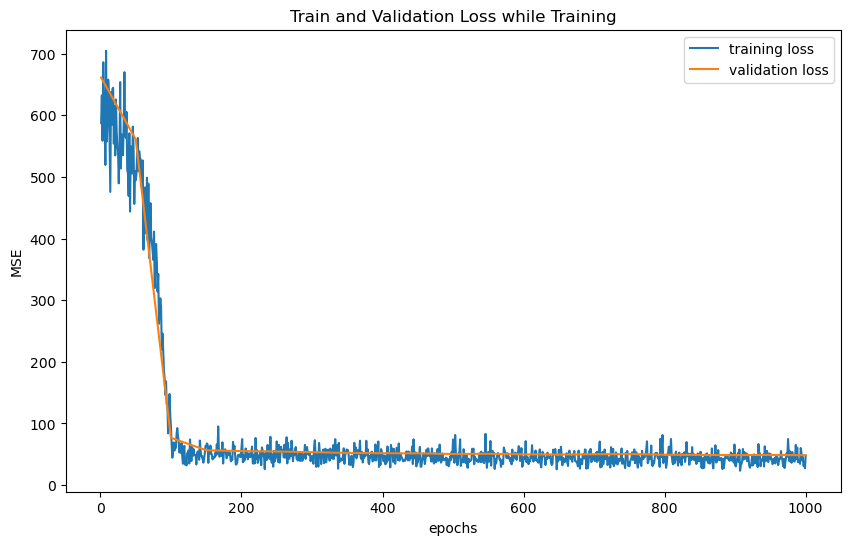

In [17]:
fl_agg.plot_training_loss()

In [18]:
y_pred = fl_agg.evaluation_metrics(x_test, y_test)

METRICS:
  Test MSE: 49.725914001464844
